<a href="https://colab.research.google.com/github/enidroman/Data-620-Web-Analysis/blob/main/Project_2_Nashville_Meetup_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Nashville Meetup Network Analysis**

 Authors: Enid Roman and Jose Rodriguez

### **Data Background**

#### **Description**
meetup.com is a website for people organizing and attending regular or semi-regular events ("meet-ups"). The relationships amongst users—who goes to what meetups—are a social network, ideal for graph-based analysis.

This dataset was generated for a talk titled Principles of Network Analysis with NetworkX.

The dataset was obtained from kaggle.com and contains 7 different datasets. Each dataset contains 6692 to 1176368 rows and 4 to 7 columns.

#### **Content**
**Graph data**

member-to-group-edges.csv: Edge list for constructing a member-to-group bipartite graph. Weights represent number of events attended in each group.

group-edges.csv: Edge list for constructing a group-to-group graph. Weights represent shared members between groups.

member-edges.csv: Edge list for constructing a member-to-member graph. Weights represent shared group membership.

rsvps.csv: Raw member-to-event attendance data, which was aggregated to form member-to-group-edges.csv.

**Metadata**

meta-groups.csv: Information for each group, including name and category. group_id can serve as index.

meta-members.csv: Information for each member, including name and location. member_id can serve as index.

meta-events.csv: Information for each event, including name and time. event_id can serve as index.

In [40]:
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from tabulate import tabulate
from prettytable import PrettyTable
from community import community_louvain as community

Because the dataset was large and github only allows 25 mb of data to be uploaded to the repository we uploaded the file in its origional state as a zip file and then downloaded to google colab by cloning the repository with !wget and unziping the file with !unzip.

In [41]:
# Clone the repository (if not already cloned)
!git clone https://github.com/enidroman/Data-620-Web-Analysis.git

# Navigate to the correct directory
%cd Data-620-Web-Analysis

# Download the zip file
!wget https://github.com/enidroman/Data-620-Web-Analysis/raw/main/NashvilleMeetUp.zip

# Unzip the file
!unzip NashvilleMeetUp.zip

Cloning into 'Data-620-Web-Analysis'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 91 (delta 30), reused 5 (delta 5), pack-reused 46
Receiving objects: 100% (91/91), 34.25 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Data-620-Web-Analysis/Data-620-Web-Analysis
--2024-03-19 03:08:16--  https://github.com/enidroman/Data-620-Web-Analysis/raw/main/NashvilleMeetUp.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/enidroman/Data-620-Web-Analysis/main/NashvilleMeetUp.zip [following]
--2024-03-19 03:08:17--  https://raw.githubusercontent.com/enidroman/Data-620-Web-Analysis/main/NashvilleMeetUp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 18

In [42]:
# Read CSV files into dataframes
group_edges = pd.read_csv('group-edges.csv')
member_edges = pd.read_csv('member-edges.csv')
member_to_group_edges = pd.read_csv('member-to-group-edges.csv')
meta_events = pd.read_csv('meta-events.csv')
meta_groups = pd.read_csv('meta-groups.csv')
meta_members = pd.read_csv('meta-members.csv')
rsvps = pd.read_csv('rsvps.csv')

Here we explore the 7 datasets.

In [43]:
# Get the number of rows and columns for each DataFrame
shapes = {
    'group_edges': group_edges.shape,
    'member_edges': member_edges.shape,
    'member_to_group_edges': member_to_group_edges.shape,
    'meta_events': meta_events.shape,
    'meta_groups': meta_groups.shape,
    'meta_members': meta_members.shape,
    'rsvps': rsvps.shape,
}

# Create a list of lists for tabulating
table_data = [[df, shape[0], shape[1]] for df, shape in shapes.items()]

# Create a pretty table
table_headers = ["DataFrame", "Number of Rows", "Number of Columns"]
pretty_table = tabulate(table_data, headers=table_headers, tablefmt="fancy_grid")

# Display the pretty table
print(pretty_table)


╒═══════════════════════╤══════════════════╤═════════════════════╕
│ DataFrame             │   Number of Rows │   Number of Columns │
╞═══════════════════════╪══════════════════╪═════════════════════╡
│ group_edges           │             6692 │                   4 │
├───────────────────────┼──────────────────┼─────────────────────┤
│ member_edges          │          1176368 │                   4 │
├───────────────────────┼──────────────────┼─────────────────────┤
│ member_to_group_edges │            45583 │                   3 │
├───────────────────────┼──────────────────┼─────────────────────┤
│ meta_events           │            19307 │                   4 │
├───────────────────────┼──────────────────┼─────────────────────┤
│ meta_groups           │              602 │                   7 │
├───────────────────────┼──────────────────┼─────────────────────┤
│ meta_members          │            24591 │                   7 │
├───────────────────────┼──────────────────┼──────────────────

In [44]:
group_edges.head()

,Unnamed: 0,group1,group2,weight
0,0,19292162,535553,2
1,1,19292162,19194894,1
2,2,19292162,19728145,1
3,3,19292162,18850080,2
4,4,19292162,1728035,1


In [45]:
member_edges.head()

,Unnamed: 0,member1,member2,weight
0,0,198737924,220654721,1
1,1,198737924,208201738,1
2,2,198737924,88664332,1
3,3,198737924,8640526,1
4,4,198737924,56356372,1


In [46]:
member_to_group_edges.head()

,member_id,group_id,weight
0,2069,19277993,3
1,625050,19277993,2
2,1939496,19277993,1
3,2606806,19277993,4
4,3438546,19277993,1


In [47]:
meta_events.head()

,event_id,group_id,name,time
0,243930425,26140018,2017 Nashville Walk to End Alzheimers - Octob...,2017-10-14 12:00:00
1,244208851,25604533,Steak Dinner on the Patio,2017-10-15 00:15:00
2,pxlktnywnbfb,25973656,Schedule Meetup,2017-10-03 23:30:00
3,244444551,18571126,"Happy Hour Wednesday, Jonathan's Green Hills, ...",2017-10-25 22:30:00
4,244257722,18571126,"Happy Hour Wednesday, Brentwood, Oct. 18",2017-10-18 22:30:00


In [48]:
meta_groups.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer
3,10016242,NashJS,1975,34,Tech,8111102,nashjs
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville


In [49]:
meta_members.head()

,member_id,name,hometown,city,state,lat,lon
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72


In [50]:
rsvps.head()

,Unnamed: 0,event_id,member_id,group_id
0,0,243930425,6770985,26140018
1,1,244208851,234724627,25604533
2,2,pxlktnywnbfb,199563568,25973656
3,3,pxlktnywnbfb,208888939,25973656
4,4,244444551,1720391,18571126


# Import data into a Graph

This code reads the csv file member to group edges which contains edges between members and groups, constructs a bipartite graph using NetworkX, and assigns attributes to nodes indicating whether they represent groups or members in a bipartite structure. The 'weight' attribute of each edge is determined by the third column of the CSV file. This bipartite graph is suitable for further analysis and visualization.

In [51]:
df = pd.read_csv('member-to-group-edges.csv')

# Iniitialize graph
G=nx.Graph()

groups=[]
members= []
for index, row in df.iterrows():
    #print(row[0], row[1], row[2])
    if row[1] not in groups:
        groups.append(row[1])
    if row[0] not in members:
            members.append(row[0])
    G.add_edge(row[1], row[0], weight=int(row[2]))

for group in groups:
    G.nodes[group]['bipartite'] = 'group'
for member in members:
    G.nodes[member]['bipartite'] = 'member'

Here we get group count and member count.

In [52]:
#Count members and groups
print(f"Group Count: {len(df['group_id'].unique())}")
print(f"Member Count: {len(df['member_id'].unique())}")

Group Count: 602
Member Count: 24631


This code reads metadata for groups from a CSV file and adds two attributes ('group_name' and 'category_name') to the corresponding nodes in the previously constructed graph G. These attributes provide additional information about each group, enriching the graph with metadata for later analysis or visualization.

In [53]:
#Adding metadata to group nodes
group_metadata = pd.read_csv('meta-groups.csv')
#group_metadata.head(2)

for _, row in group_metadata.iterrows():
    G.nodes[row['group_id']]['group_name'] = row['group_name']
    G.nodes[row['group_id']]['category_name'] = row['category_name']

This function returns True if the graph is bipartite and False otherwise.

In [54]:
print(bi.is_bipartite(G))

True


# Examining Connected Components
This allows for focus to be directed to the largest component of the graph. In this case, the first component has 25171 nodes making it our focus.

In [55]:
nx.is_connected(G)

False

In [56]:
nx.number_connected_components(G)

25

In [57]:
#Check size of components in the orignal network
x=[len(c) for c in nx.connected_components(nx.Graph(G))]
x

[25171, 2, 2, 2, 2, 2, 5, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2, 7, 2, 2, 2, 2, 3, 2]

This code helps identify and extract the largest connected component in the graph G and provides information about the size of this component in terms of the number of nodes.

G: This is the original bipartite graph that we created and populated with nodes and edges.

Gcc = sorted(nx.connected_components(G), key=len, reverse=True): This line identifies the connected components in the bipartite graph G and sorts them by length in descending order.

G0 = G.subgraph(Gcc[0]): This line extracts the largest connected component and creates a subgraph G0 containing only the nodes and edges of that component.






In [58]:
#Extracting largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
print(f"No. of Nodes: {len(G0.nodes())}")

No. of Nodes: 25171


This line of code is verifying whether the largest connected component (subgraph G0) is a connected graph or not. If it returns True, it means all nodes in G0 are connected, forming a single connected component. If it returns False, there might be isolated nodes or disconnected components within G0.

In [59]:
nx.is_connected(G0)

True

### Creating Node Set References

This part of the code is providing information about the number of groups (top_nodes) and members (bottom_nodes) in the largest connected component of the bipartite graph G0.

In [60]:
top_nodes, bottom_nodes = nx.bipartite.sets(G0)
print(len(top_nodes)) #groups
print(len(bottom_nodes)) #members

578
24593


#### Inspecting G0 Centrality


The degree centrality is a measure of the number of edges that a node has in the graph, indicating its level of connectivity within the network.

In [61]:
#top 20 member nodes by degree
degree_G0 = dict(nx.degree(G0))
member_degree_G0 = {n: degree for n, degree in degree_G0.items() if n in bottom_nodes}
top_member_nodes = sorted(member_degree_G0.items(), key=lambda x: x[1], reverse=True)
top_20_members = top_member_nodes[:20]

for node, degree in top_20_members:
    print(f"Node: {node}, Degree: {degree}")

Node: 8539046, Degree: 42
Node: 5900662, Degree: 34
Node: 126066112, Degree: 32
Node: 175300482, Degree: 31
Node: 46486792, Degree: 30
Node: 3949436, Degree: 29
Node: 134073882, Degree: 28
Node: 3380276, Degree: 27
Node: 81924252, Degree: 27
Node: 144256692, Degree: 27
Node: 60195472, Degree: 25
Node: 56997982, Degree: 25
Node: 12977589, Degree: 25
Node: 203244569, Degree: 24
Node: 166082312, Degree: 24
Node: 221191725, Degree: 23
Node: 220624758, Degree: 23
Node: 129122472, Degree: 22
Node: 4169858, Degree: 21
Node: 206481851, Degree: 21


### Examining Node and Edge Information

We took a quick look of three elements in the edges: the source node, the target node, and a dictionary of attributes associated with the edge, such as the weight of the edge

In [62]:
#Check attributes for an edge:
for edge in G0.edges(data=True):
    print(edge)
    break

(19277993, 2069, {'weight': 3})


We took a quick look at each node, containing two elements: the node identifier and a dictionary of attributes associated with that node. This allows us to inspect the attributes of the first few nodes in the graph, providing insights into the metadata or properties associated with each node in the bipartite graph G0.

In [63]:
#Check attributes for a node:
for i, node in enumerate(G0.nodes(data=True)):
    print(node)
    if i == 3:
        break

(19277993, {'bipartite': 'group', 'group_name': 'Nashville DevOps Meetup', 'category_name': 'Tech'})
(2069, {'bipartite': 'member'})
(625050, {'bipartite': 'member'})
(1939496, {'bipartite': 'member'})


### Examining Top Member Nodes by Degree Centrality

This code segment identifies and extracts nodes that belong to the 'member' bipartite set in the graph G0. It then calculates the degree (number of connections) for each member node and selects the top 20 nodes based on their degrees.

In [64]:
member_nodes = [node for node, attr in G0.nodes(data=True) if attr['bipartite'] == 'member']

node_degrees_G0 = dict(G0.degree(member_nodes))
top_nodes_degree = set(sorted(node_degrees_G0.items(), key=lambda x: x[1], reverse=True)[:20])

This code provides information about the top 20 member nodes in G0 based on their degrees.

In [65]:
print("Member ID - Degree Centrality")
list(top_nodes_degree)

Member ID - Degree Centrality


[(4169858, 21),
 (8539046, 42),
 (3380276, 27),
 (129122472, 22),
 (3949436, 29),
 (5900662, 34),
 (175300482, 31),
 (203244569, 24),
 (166082312, 24),
 (46486792, 30),
 (81924252, 27),
 (206481851, 21),
 (56997982, 25),
 (126066112, 32),
 (12977589, 25),
 (221191725, 23),
 (134073882, 28),
 (220624758, 23),
 (144256692, 27),
 (60195472, 25)]

### Projecting Bipartite Graph Onto Member Nodes

This projected graph M provides a view of the connections and weights between individual member nodes in the original bipartite graph G0.

In [66]:
#Project bipartite graph  onto member nodes
M = nx.bipartite.weighted_projected_graph(G0, bottom_nodes) #members set

In this code, the degree of each node in the projected graph M is calculated and then the nodes are sorted by their degrees in descending order.

In [67]:
# node_degrees_M = dict(M.degree())

# # Sort nodes by their degrees in descending order
# sorted_nodes_M = sorted(node_degrees_M.items(), key=lambda x: x[1], reverse=True)

# # Print the nodes and their corresponding degrees in descending order
# for i, (node, degree) in enumerate(sorted_nodes_M):
#     print(f"Iteration: {i} - Node {node}: Degree {degree}")
#     if i == 3:
#         break

Here we implement the Island Method on a graph. This Island Method is commonly used to identify significant structures or communities within a graph by gradually removing edges with lower weights. The result is a series of subgraphs representing different levels of connectivity.

In [68]:
#Check for subgraphs using the Island Method
#Initialize functions to trim and 'islandize' components
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        #print(f, to, edata, " ", type(edata), edata['weight'])
        #print(edata)
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2

def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    #print(weights)
    mn= int(min(weights))
    mx= int(max(weights))
    step= int((mx-mn)/iterations)
    return [[threshold,trim_edges(g,threshold)] for threshold in range(mn,mx,step)]

#### Viewing Island Threshold Results for Core Component 'G0'

This code provides insights into the structure of the graph G0 at different weight thresholds, helping to identify how the graph's connectivity changes as edges with lower weights are progressively removed.

In [69]:
islands_G0 = island_method(G0)

for i in islands_G0:
    #print("Threshold - ", "# Nodes -", "# Islands")
    print("Threshold - ",i[0], "# Nodes -",len(i[1]), "# Islands -", len([len(c) for c in nx.connected_components(i[1])]))

Threshold -  1 # Nodes - 12002 # Islands - 51
Threshold -  40 # Nodes - 311 # Islands - 88
Threshold -  79 # Nodes - 127 # Islands - 50
Threshold -  118 # Nodes - 46 # Islands - 22
Threshold -  157 # Nodes - 17 # Islands - 8
Threshold -  196 # Nodes - 8 # Islands - 4


The Island Method applied to the original bipartite graph G0 reveals intriguing connectivity patterns and island structures. At a low threshold of 1, the graph is relatively connected, comprising 12,002 nodes distributed across 51 islands. As the threshold increases to 40, the network undergoes a significant transformation, with a notable reduction in nodes (311) and a simultaneous surge in the number of islands (88). Subsequent thresholds of 79, 118, 157, and 196 lead to a progressive decrease in the number of nodes (127, 46, 17, and 8, respectively) and a corresponding rise in the number of islands. These findings underscore the sensitivity of the graph's connectivity to weight thresholds, revealing distinct community structures and shedding light on the intricate relationships among the nodes. The identified islands at various thresholds provide valuable insights into the modular nature of the bipartite graph, offering a nuanced understanding of the underlying connectivity dynamics.

#### Viewing Island Thresholds Results for Projected Members Graph 'M'


The application of the Island Method to the projected graph, denoted as M, reveals intriguing insights into the connectivity patterns of the member nodes.

When the threshold is increased from 7 to 9, the number of islands increase.

In [70]:
islands_M = island_method(M)

for i in islands_M:
    #print("Threshold - ", "# Nodes -", "# Islands")
    print("Threshold - ",i[0], "# Nodes -",len(i[1]), "# Islands -", len([len(c) for c in nx.connected_components(i[1])]))

Threshold -  1 # Nodes - 7517 # Islands - 27
Threshold -  3 # Nodes - 1489 # Islands - 12
Threshold -  5 # Nodes - 404 # Islands - 5
Threshold -  7 # Nodes - 128 # Islands - 3
Threshold -  9 # Nodes - 38 # Islands - 6
Threshold -  11 # Nodes - 7 # Islands - 3
Threshold -  13 # Nodes - 2 # Islands - 1


The Island Method applied to the weighted projected graph M unveils intriguing connectivity dynamics among the member nodes. At a low threshold of 1, a substantial cohesive network emerges, comprising 7,517 nodes and forming 27 islands. As the threshold increases to 3, the network undergoes a transformation, with a reduction in nodes (1,489) and a concurrent increase in the number of islands (12). This trend continues with successive thresholds of 5, 7, 9, 11, and 13, resulting in a progressive decline in nodes (404, 128, 38, 7, and 2, respectively) and an associated rise in the number of islands. These findings highlight the evolving structural patterns within the member node network and emphasize the impact of weight thresholds on the connectivity dynamics. The identified islands at various thresholds provide valuable insights into the underlying community structures, offering a nuanced understanding of the relationships among the member nodes in the projected graph.

The plot below visualizes a subgraph extracted from the original bipartite graph M by applying a weight threshold of 9. The resulting graph, denoted as M9, exhibits distinct node degrees, represented by varying node sizes. Each node's size is proportional to its degree, offering insights into the structural importance of individual members within the community. The use of spring layout aids in revealing potential community structures and highlighting nodes with higher degrees. The nodes are labeled, and their sizes provide a visual representation of their connectivity. This plot serves as a valuable tool for exploring the intricate relationships among members within the bipartite network, emphasizing the significance of the Island Method in uncovering underlying structures and connectivity dynamics.






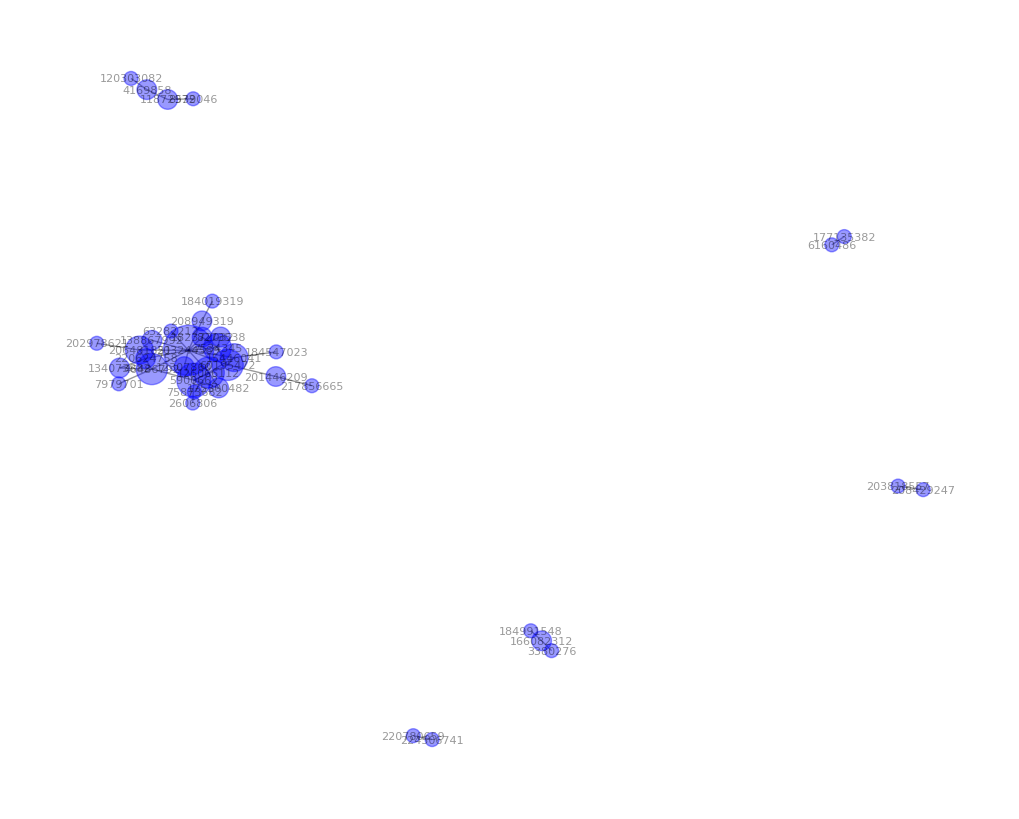

In [71]:
#Plot subgraphs based on islands
M9 = trim_edges(M, 9)
M9_deg = M9.degree()

# Calculate the degree of each node
node_degrees_M9 = dict(M9.degree())
sizes = [node_degrees_M9[node] * 15 for node in M9.nodes()]

#plot
pos = nx.spring_layout(M9)
plt.figure(figsize=(10, 8))
nx.draw(M9, pos=pos, node_size=[v*100 for v in node_degrees_M9.values()], with_labels=True, node_color='b', alpha=.4, font_size=8)

The top 20 member nodes in the subgraph M9 are identified based on their degree centrality. Degree centrality measures the proportion of direct connections a node has to other nodes in the network. In this context, it reflects the prominence of members within the specified weighted subgraph. The list showcases the nodes with the highest degree centrality, providing valuable insights into the key contributors to the connectivity and structure of the bipartite network. Understanding these central members is crucial for unraveling the dynamics and influence within the community, aiding in targeted analyses and decision-making processes related to the network.

In [72]:
#M9 top 20 member degree centrality
degree_centrality_M9 = nx.degree_centrality(M9)
member_centrality_M9 = {n: centrality for n, centrality in degree_centrality_M9.items() if n in bottom_nodes}
top_member_nodes = sorted(member_centrality_M9.items(), key=lambda x: x[1], reverse=True)
top_20_members = top_member_nodes[:20]

for node, centrality in top_20_members:
    print(f"Node: {node}, Degree Centrality: {centrality}")

Node: 203244569, Degree Centrality: 0.35135135135135137
Node: 5900662, Degree Centrality: 0.16216216216216217
Node: 60195472, Degree Centrality: 0.13513513513513514
Node: 46486792, Degree Centrality: 0.13513513513513514
Node: 126066112, Degree Centrality: 0.13513513513513514
Node: 7534345, Degree Centrality: 0.10810810810810811
Node: 15446041, Degree Centrality: 0.10810810810810811
Node: 206481851, Degree Centrality: 0.10810810810810811
Node: 12307860, Degree Centrality: 0.05405405405405406
Node: 175300482, Degree Centrality: 0.05405405405405406
Node: 166082312, Degree Centrality: 0.05405405405405406
Node: 201446209, Degree Centrality: 0.05405405405405406
Node: 8273538, Degree Centrality: 0.05405405405405406
Node: 11872972, Degree Centrality: 0.05405405405405406
Node: 208949319, Degree Centrality: 0.05405405405405406
Node: 220624758, Degree Centrality: 0.05405405405405406
Node: 134073882, Degree Centrality: 0.05405405405405406
Node: 138867992, Degree Centrality: 0.05405405405405406
Nod

The visualization of the subgraph M9 below is presented using the Kamada-Kawai layout algorithm. This layout algorithm aims to arrange nodes in a way that minimizes the number of edge crossings and provides a visually appealing representation of the network. In the plot, each node is sized proportionally to its degree, emphasizing the importance of highly connected members within the subgraph. The blue color of the nodes and the alpha parameter contribute to the clarity of the graph, making it easier to discern the structure and relationships among the members. This visualization serves as a powerful tool for gaining insights into the connectivity patterns and centrality of members within the specific threshold-weighted subgraph.

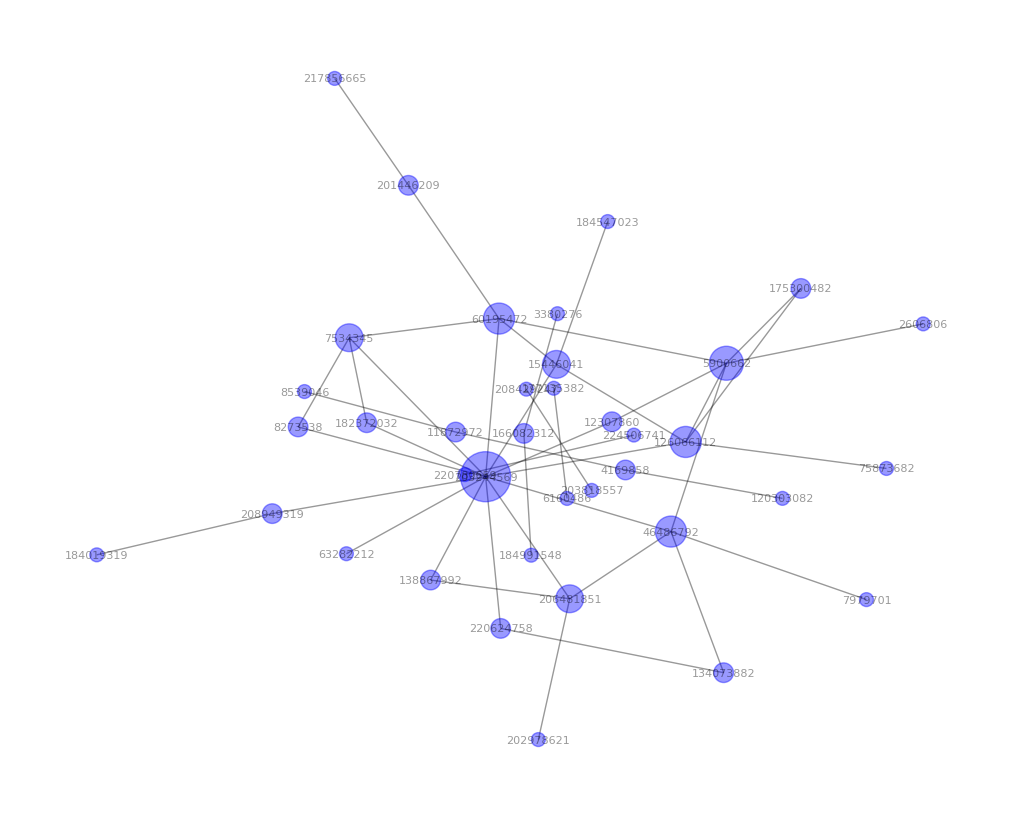

In [73]:
#plot
pos = nx.kamada_kawai_layout(M9)
plt.figure(figsize=(10, 8))
nx.draw(M9, pos=pos, node_size=[v*100 for v in node_degrees_M9.values()], with_labels=True, node_color='b', alpha=.4, font_size=8)

# Reconstruct Bipartite Graph with Island

The create_bipartite_with_groups function facilitates the construction of a bipartite graph from a specified subgraph and its corresponding original graph. It identifies 'member' nodes and their associated 'group' neighbors within the subgraph, adding these nodes to a new bipartite graph while preserving their bipartite attributes. The function also establishes edges between 'member' nodes and their 'group' neighbors in the bipartite graph, incorporating edge data from the original graph. This enables a simplified representation of the bipartite structure within the subgraph, aiding in the analysis and visualization of relationships between different node types in the original graph.

In [74]:
def create_bipartite_with_groups(subgraph, original_graph):
    # Initialize a new graph for constructing the bipartite structure
    bipartite_graph = nx.Graph()

    # Temporarily hold 'member' nodes and their 'group' neighbors
    member_nodes = [node for node in subgraph.nodes() if node in original_graph and original_graph.nodes[node].get('bipartite') == 'member']
    group_neighbors = set()

    # Collect all 'group' neighbors for each 'member' node
    for member_node in member_nodes:
        neighbors = [neighbor for neighbor in original_graph.neighbors(member_node) if original_graph.nodes[neighbor].get('bipartite') == 'group']
        group_neighbors.update(neighbors)

    # Add 'member' nodes to the bipartite graph
    for node in member_nodes:
        bipartite_graph.add_node(node, bipartite='member')

    # Add 'group' nodes to the bipartite graph
    for node in group_neighbors:
        bipartite_graph.add_node(node, bipartite='group')

    # Add edges between 'member' nodes and their 'group' neighbors
    for member_node in member_nodes:
        for neighbor in original_graph.neighbors(member_node):
            if neighbor in group_neighbors:
                edge_data = original_graph.get_edge_data(member_node, neighbor)
                bipartite_graph.add_edge(member_node, neighbor, **edge_data)

    return bipartite_graph

The resulting visualization below creates a bipartite graph (M9_BP) from a specified subgraph (M9) of the original graph (G0). Using the create_bipartite_with_groups function, 'group' and 'member' nodes are organized, and node degrees are calculated. The resulting visualization showcases the bipartite structure, with 'group' nodes in red and 'member' nodes in blue. Node sizes are proportional to their degrees, and the graph includes edge connections and node labels, offering a clear representation of the relationships within the bipartite graph.

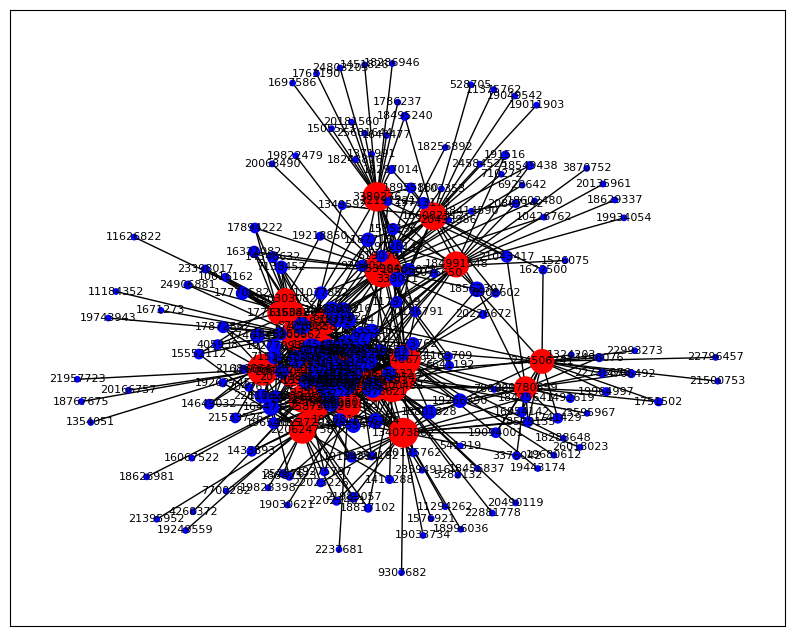

In [75]:
M9_BP = create_bipartite_with_groups(M9, G0)

top_nodes, bottom_nodes = nx.bipartite.sets(G0)

# Calculate the degree of each node
node_degrees = dict(M9_BP.degree())

# Define colors for each bipartite category
color = []
for node in M9_BP.nodes():
  if node in bottom_nodes:
    color.append('red')
  if node in top_nodes:
    color.append('blue')

#Define node sizes based on their degrees
sizes = []#[node_degrees[node] * 15 for node in M9_BP.nodes()]
for node in M9_BP.nodes():
  sizes.append(node_degrees[node]*15)

# Create a layout
pos = nx.spring_layout(M9_BP)
plt.figure(figsize=(10, 8))

# Plot nodes
nx.draw_networkx_nodes(M9_BP, pos, node_color=color, node_size=sizes)

# Plot edges
nx.draw_networkx_edges(M9_BP, pos)

# Plot labels
nx.draw_networkx_labels(M9_BP, pos, font_size=8)

# Show the plot
plt.show()

In [76]:
bi.is_bipartite(M9_BP)

True

The below visualization generates a bipartite graph (M11_BP) from a subgraph (M11) of the original graph (G0). In this visualization, 'group' nodes are depicted in red, and 'member' nodes are in blue. The node sizes are determined by their degrees, with larger nodes indicating higher degrees. The layout is created using the bipartite layout method, providing a clear distinction between 'group' and 'member' nodes. Additionally, the code includes edge connections and node labels, offering a comprehensive representation of the relationships within the bipartite graph.

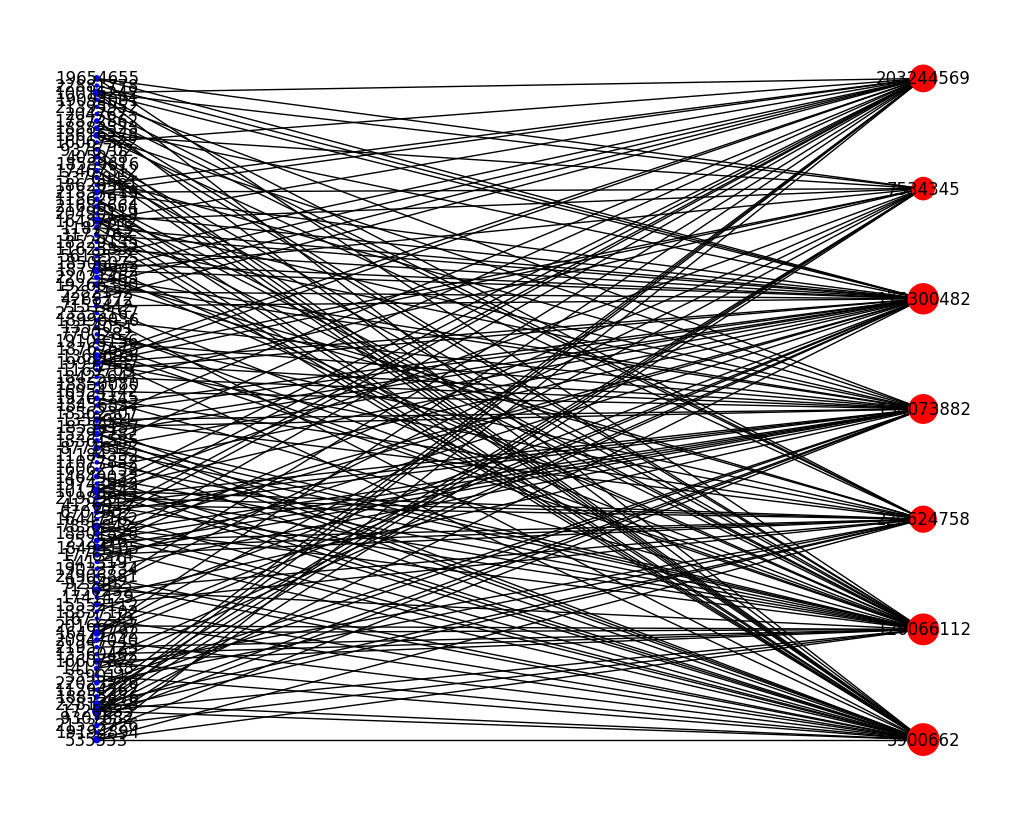

In [77]:
M11 = trim_edges(M, 11)
M11_BP = create_bipartite_with_groups(M11, G0)

top_nodes, bottom_nodes = nx.bipartite.sets(G0)

# Calculate the degree of each node
node_degrees = dict(M11_BP.degree())
color = []
for node in M11_BP.nodes():
  if node in bottom_nodes:
    color.append('red')
  else:
    color.append('blue')


sizes = []#[node_degrees[node] * 100 for node in M11_BP.nodes()]
for node in M11_BP.nodes():
  if node in top_nodes:
    sizes.append(node_degrees[node] * 5)
  else:
    sizes.append(node_degrees[node] * 15)

top_nodes, bottom_nodes = nx.bipartite.sets(M11_BP)

# Create the bipartite layout
plt.figure(figsize=(10, 8))
# pos = dict()
# pos.update((n, (1, i)) for i, n in enumerate(bottom_nodes))
# pos.update((n, (2, i)) for i, n in enumerate(top_nodes))
pos = nx.bipartite_layout(M11_BP, bottom_nodes)

labels = {node: node for node in M11_BP.nodes()}

# Draw the bipartite graph
nx.draw(M11_BP, pos=pos, with_labels=True,node_color=color, node_size=sizes, labels=labels)

# Show the plot
plt.show()

In the exploration of a bipartite graph representing the intricate relationships between groups and their corresponding members, a multitude of insights emerge, shedding light on the nuanced dynamics within each distinct group. The application of various analytical techniques, including the island method, centrality metrics, and visualizations, provides a comprehensive understanding of the network's structure and the roles played by different entities.

The identified groups exhibit a diverse range of structural characteristics, illustrating the complexity inherent in collaborative networks. Some groups appear as tightly interconnected clusters, suggesting a high degree of collaboration and shared activities among their members. Conversely, other groups display a more dispersed structure, hinting at potentially loose associations among their members. The island method, employed with different connectivity thresholds, allows for the observation of how the coherence of these groups changes with varying levels of interconnectedness. Higher thresholds result in fewer but more tightly-knit groups, emphasizing the importance of understanding the interdependence within these units.

Centrality metrics, such as degree centrality, offer valuable insights into the influence and connectivity of individual members within the groups. Certain members emerge as central connectors, signifying a higher number of connections and potentially playing pivotal roles in facilitating communication or collaboration. This centrality analysis is instrumental in identifying key nodes that contribute significantly to the overall cohesion and functioning of their respective groups.

The size and isolation of groups at different connectivity thresholds reveal additional layers of information about their dynamics. Some groups exhibit resilience, remaining connected even at higher thresholds, indicating robust interdependence. In contrast, certain groups fragment into smaller, more isolated components, suggesting potential subgroups or entities with distinct characteristics. This nuanced understanding of group dynamics contributes to a more comprehensive view of how collaboration and interaction manifest within the network.

Visualizations play a crucial role in elucidating the bipartite relationship between 'group' and 'member' nodes. These visual representations provide insights into the collaborative dynamics between groups and their respective members, offering an intuitive understanding of the overall network architecture. The structural patterns within the bipartite graph become apparent, contributing to a more profound grasp of the relationships at play.

Analyzing the top nodes, especially in terms of degree centrality, highlights variations in importance among different groups or members. Some entities emerge as central connectors, playing pivotal roles within the network, while others assume more peripheral positions. These centrality differences underscore the heterogeneity within the network, reflecting the diverse contributions and influences of different entities.

In conclusion, the amalgamation of the island method, centrality metrics, and visualizations provides a rich tapestry of insights into the distinct groups within the bipartite graph. This exploration enhances our understanding of collaboration patterns, member influence, and the overall structure of the network. While these findings offer a solid foundation, further domain-specific knowledge and detailed investigation would be essential to derive specific interpretations or actionable insights from the observed network dynamics.



